In [3]:
%store -r g_junk

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid" ,font_scale=1.8)

In [5]:
data = g_junk.drop(['App Name', 'Released'], axis=1).copy()

In [6]:
names = data.columns
scaler = MinMaxScaler()
scaled_d = scaler.fit_transform(data[['Size', 'Installs']])
data[['Size', 'Installs']] = scaled_d

Usiamo uno scaler differente per installs, perché il numero di installs ha una grande variabilità che non verrebbe apprezzata in uno scaling (0,1), empiricamente abbiamo visto che lo scaling (0,1e4) migliora le performance di logistic regression, e non è peggiorativo sugli altri modelli.

In [7]:
scaler = MinMaxScaler(feature_range=(0,1e4))
scaled_d = scaler.fit_transform(data[['Rating Count']])
data['Rating Count'] = scaled_d

In [8]:
data.Rating = data.Rating.apply(lambda x: round(x))
rating_0 = data[data.Rating == 0]
rating_1 = data[data.Rating == 1]
rating_2 = data[data.Rating == 2]
rating_3 = data[data.Rating == 3]
rating_4 = data[data.Rating == 4]
rating_5 = data[data.Rating == 5]
print("rating_0: ", len(rating_0), "rating_1: ", len(rating_1), " rating_2: ", len(rating_2), "rating_3: ", len(rating_3), "rating_4: ", len(rating_4), "rating_5: ", len(rating_5))

rating_0:  1038326 rating_1:  2930  rating_2:  38965 rating_3:  142860 rating_4:  677730 rating_5:  340870


In [9]:
myclasses = {0:0, 1:0, 2:0, 3:1, 4:1, 5:1}
myclasses_t = {0:0, 1:0, 2:1, 3:1, 4:2, 5:2}
random_seed = 10

In [10]:
def reduce_to_one_class(series: pd.Series, cla: dict) -> pd.Series:
    return series.apply(lambda x: cla[x])

In [103]:
junk = pd.concat([rating_0, rating_1, rating_2])
junk.Rating = reduce_to_one_class(junk.Rating, myclasses)
top = pd.concat([rating_3, rating_4, rating_5])
top.Rating = reduce_to_one_class(top.Rating, myclasses)
balanced_b = pd.concat([junk, top.sample(len(junk), random_state=random_seed)])

In [11]:
junk_t = pd.concat([rating_0, rating_1])
junk_t.Rating = reduce_to_one_class(junk_t.Rating, myclasses_t)
middle_t = pd.concat([rating_2, rating_3])
middle_t.rating = reduce_to_one_class(middle_t.Rating, myclasses_t)
top_t = pd.concat([rating_4, rating_5])
top_t.Rating = reduce_to_one_class(top_t.Rating, myclasses_t)
balanced_t = pd.concat([pd.concat([top_t, junk_t.sample(len(top_t), random_state=random_seed)]).sample(len(middle_t), random_state=random_seed), middle_t])

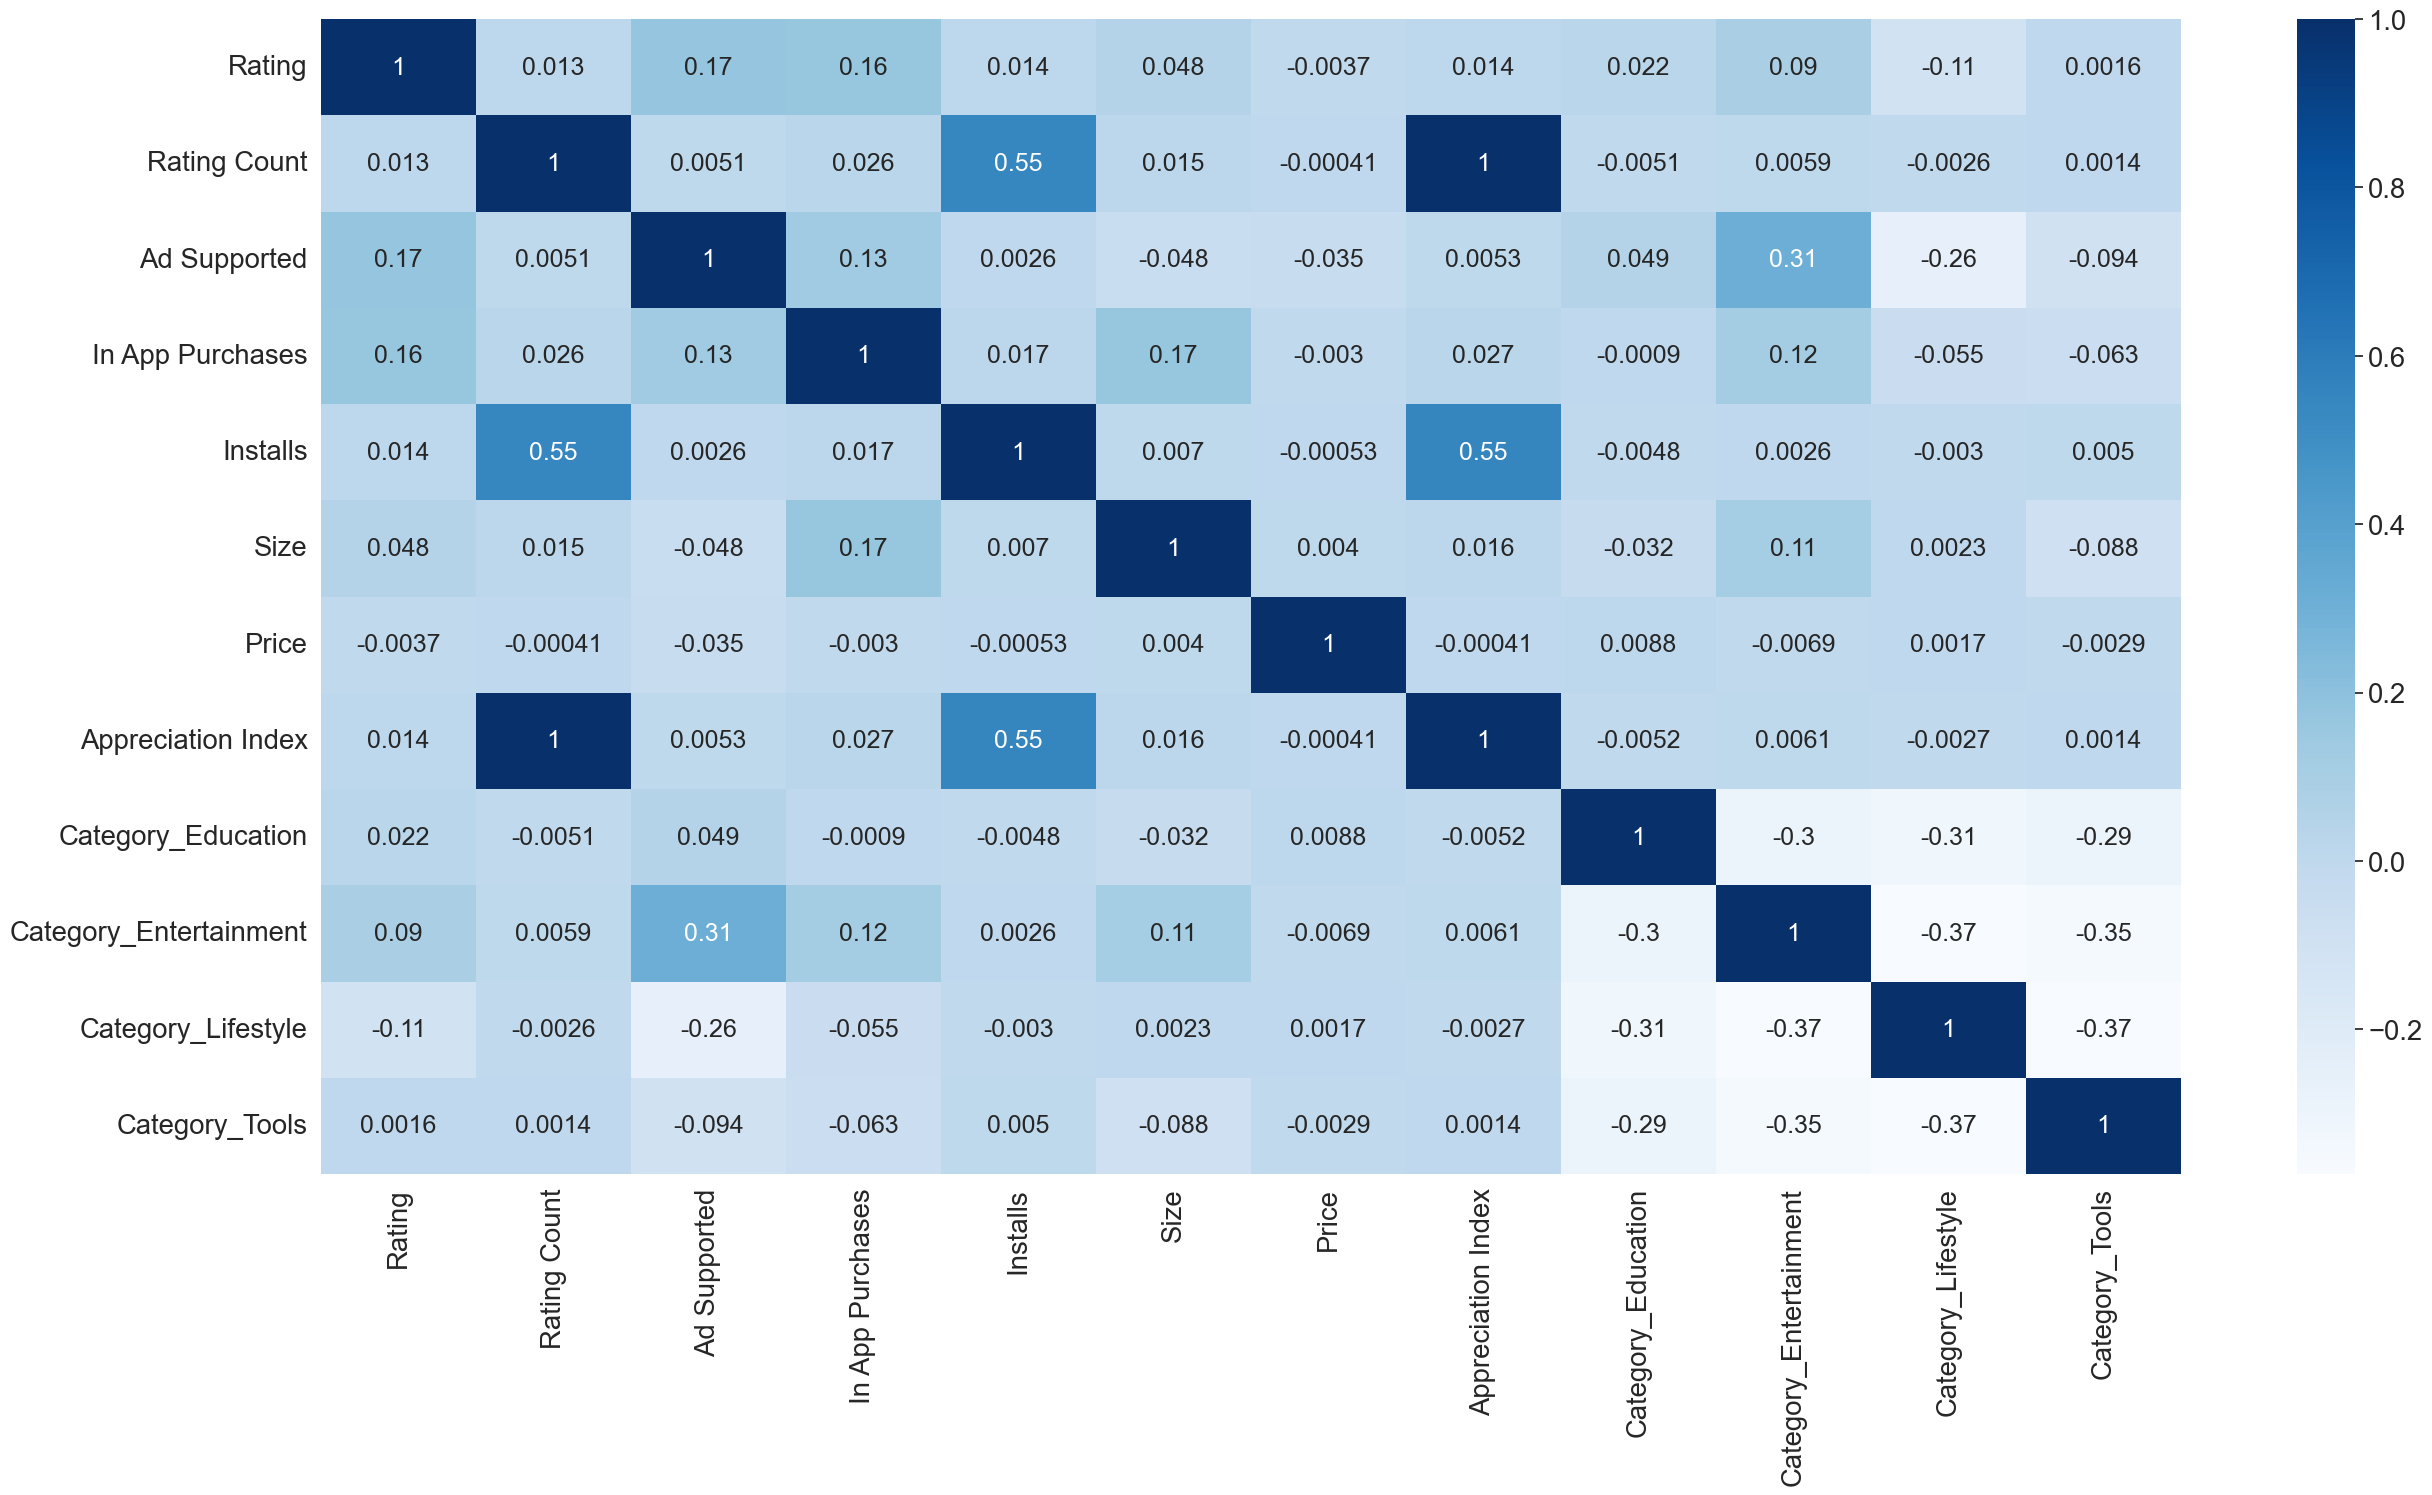

In [105]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(balanced_b[balanced_b.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [106]:
balanced_b.drop(['Installs', 'Appreciation Index'], axis=1, inplace=True)

In [12]:
balanced_t.drop(['Installs', 'Appreciation Index'], axis=1, inplace=True)

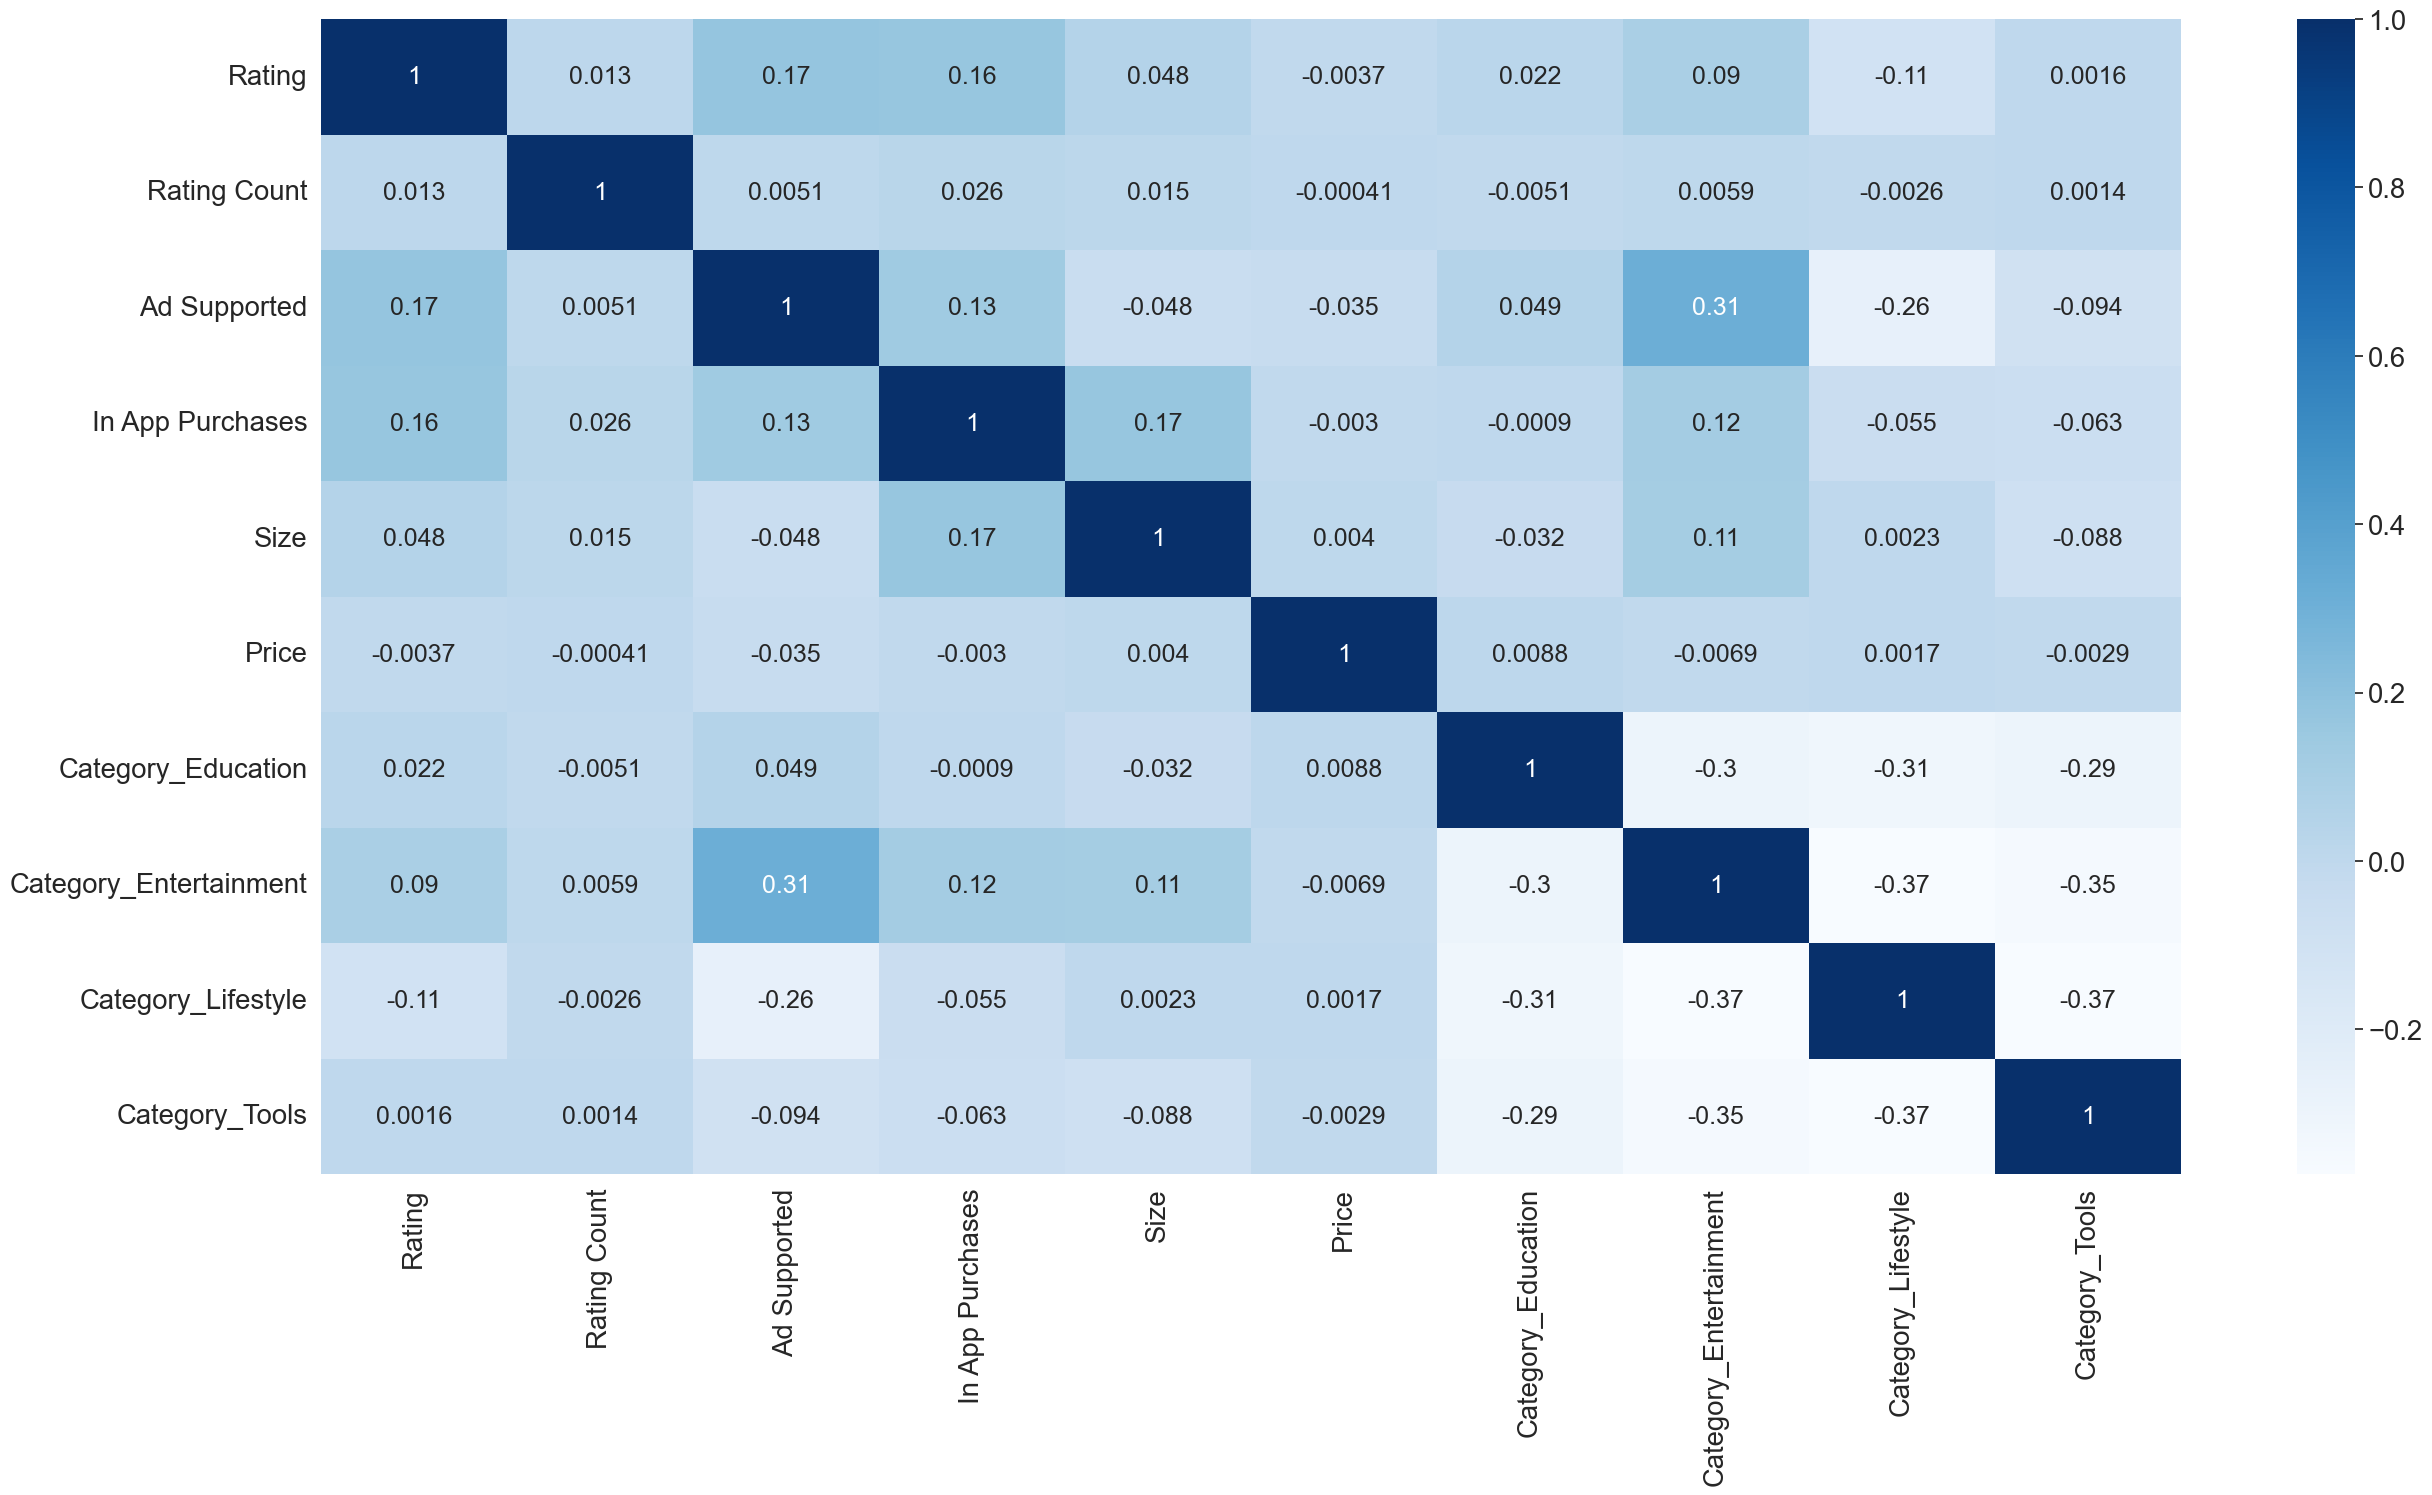

In [108]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(balanced_b[balanced_b.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [109]:
label = pd.get_dummies(balanced_b["Rating"], prefix = "rating") 
features = balanced_b.drop("Rating", axis=1)
rs = 1
train_features, test_features, train_labels, test_labels = train_test_split(features, label, test_size=0.1)

Multi-layer perceptron

In [110]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 20, 40, 6), max_iter=20,
validation_fraction=0.1, early_stopping=True, verbose=True, n_iter_no_change=10,
activation='relu', solver='adam', batch_size=32, momentum=0.9,
learning_rate='adaptive', random_state=rs)

mlp.fit(train_features.values, train_labels.rating_1.values)

Iteration 1, loss = 0.18043690
Validation score: 0.974861
Iteration 2, loss = 0.10010427
Validation score: 0.978976
Iteration 3, loss = 0.09685550
Validation score: 0.979814
Iteration 4, loss = 0.09399207
Validation score: 0.979634
Iteration 5, loss = 0.09202924
Validation score: 0.979557
Iteration 6, loss = 0.09278976
Validation score: 0.979896
Iteration 7, loss = 0.09207105
Validation score: 0.979613
Iteration 8, loss = 0.09123847
Validation score: 0.979855
Iteration 9, loss = 0.09179292
Validation score: 0.979408
Iteration 10, loss = 0.09168891
Validation score: 0.978718
Iteration 11, loss = 0.09032080
Validation score: 0.979629
Iteration 12, loss = 0.08971218
Validation score: 0.978888
Iteration 13, loss = 0.08982609
Validation score: 0.961988
Iteration 14, loss = 0.08867826
Validation score: 0.979948
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(batch_size=32, early_stopping=True,
              hidden_layer_sizes=(10, 20, 40, 6), learning_rate='adaptive',
              max_iter=20, random_state=1, verbose=True)

In [111]:
acc_during_train = mlp.score(train_features.values, train_labels.rating_1.values)
print('Accuratezza durante il training :', acc_during_train)
accuracy = mlp.score(test_features.values, test_labels.rating_1.values)
print(f'Accuratezza : {round(accuracy, 2)}   ---> {mlp.__class__.__name__}')

Accuratezza durante il training : 0.9801835736220535
Accuratezza : 0.98   ---> MLPClassifier


In [112]:
random_features = balanced_b.sample(n=100)
random_raw = pd.get_dummies(random_features["Rating"], prefix = "rating")
random_features.drop("Rating", axis=1, inplace=True)

In [113]:
pred = mlp.predict(test_features.values)

In [114]:
def check_pred(pred, givn):
    comp = list()
    for el in zip(pred, givn):
        if len(el) <= 2:
            if el[0] == el[1]:
                comp.append(True)
            else:
                comp.append(False)
        else :
            if all(el[0] == el[1]):
                comp.append(True)
            else :
                comp.append(False)
    comp = [el for el in zip(pred, givn, comp)]
    return comp

comp = check_pred(pred, test_labels.rating_1.values)

Altri classificatori

In [115]:
classifiers = [
    LogisticRegression(random_state = rs),
    DecisionTreeClassifier(random_state=rs),
    SVC(probability=True, random_state=rs, max_iter=10),
    KNeighborsClassifier(),
    RandomForestClassifier(n_estimators = 10, random_state=rs),
]

clf_name = [] 
model_results = pd.DataFrame.copy(test_labels)

kfold = StratifiedKFold(n_splits=5)
cv_results = [] 
cv_acc = []
cv_std = [] 
cnfm = []
clr = []
roc_auc = [] 
roc_tpr = []
roc_fpr = [] 

In [116]:
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)
    
    model = clf.fit(train_features, train_labels.rating_1)
    y_pred = model.predict(test_features)
    model_results[name] = y_pred
    
    cv_results.append(cross_val_score(clf, train_features, train_labels.rating_1, scoring = "accuracy",cv = kfold))
    acc = round(accuracy_score(test_labels.rating_1, y_pred), 2)
    train_pred = clf.predict_proba(test_features)
    print(f'Accuracy: {acc} \t ---> {name} ')

    cnfm.append(confusion_matrix(test_labels.rating_1, y_pred))
    clr.append(classification_report(test_labels.rating_1, y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, test_labels.rating_1)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)

Accuracy: 0.75 	 ---> LogisticRegression 
Accuracy: 0.97 	 ---> DecisionTreeClassifier 
Accuracy: 0.51 	 ---> SVC 
Accuracy: 0.98 	 ---> KNeighborsClassifier 
Accuracy: 0.98 	 ---> RandomForestClassifier 


aggiungo ai risultati degli altri 4 modelli anche quelli del MLP

In [117]:
name = mlp.__class__.__name__
clf_name.append(name)
classifiers.append(mlp)
model_results[name] = pred
cv_results.append(cross_val_score(mlp, train_features, train_labels.rating_1, scoring = "accuracy",cv = kfold))
accuracy_rounded = round(accuracy, 2)
cnfm.append(confusion_matrix(test_labels.rating_1, pred))
clr.append(classification_report(test_labels.rating_1, pred))
fpr, tpr, thresholds = roc_curve(pred, test_labels.rating_1)
roc_auc.append(auc(fpr, tpr))
roc_tpr.append(tpr)
roc_fpr.append(fpr)

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())

Iteration 1, loss = 0.19525991
Validation score: 0.977525
Iteration 2, loss = 0.10382485
Validation score: 0.978631
Iteration 3, loss = 0.09902884
Validation score: 0.979338
Iteration 4, loss = 0.09602908
Validation score: 0.979480
Iteration 5, loss = 0.09519804
Validation score: 0.980161
Iteration 6, loss = 0.09313109
Validation score: 0.978265
Iteration 7, loss = 0.09377087
Validation score: 0.978657
Iteration 8, loss = 0.09201096
Validation score: 0.979878
Iteration 9, loss = 0.09230791
Validation score: 0.979267
Iteration 10, loss = 0.09135725
Validation score: 0.980315
Iteration 11, loss = 0.09167984
Validation score: 0.960721
Iteration 12, loss = 0.09105491
Validation score: 0.980007
Iteration 13, loss = 0.09047650
Validation score: 0.980077
Iteration 14, loss = 0.09019162
Validation score: 0.979518
Iteration 15, loss = 0.09009346
Validation score: 0.979923
Iteration 16, loss = 0.08916810
Validation score: 0.980174
Iteration 17, loss = 0.08898964
Validation score: 0.980122
Iterat

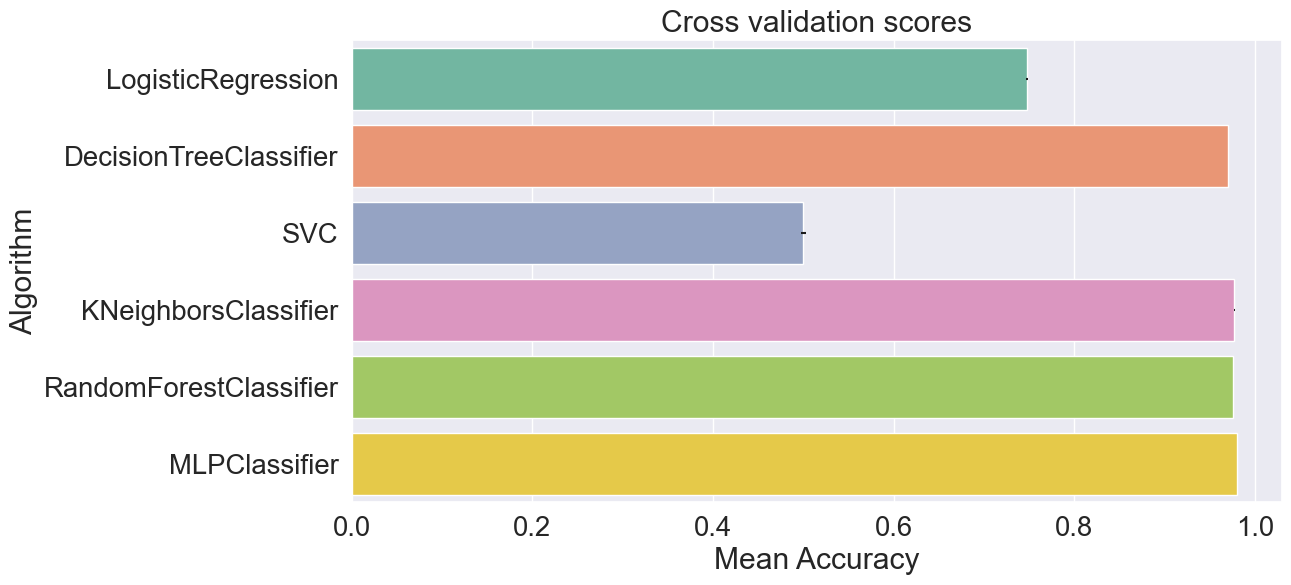

In [118]:
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})
plt.figure(figsize=(12,6))
sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")
plt.show()

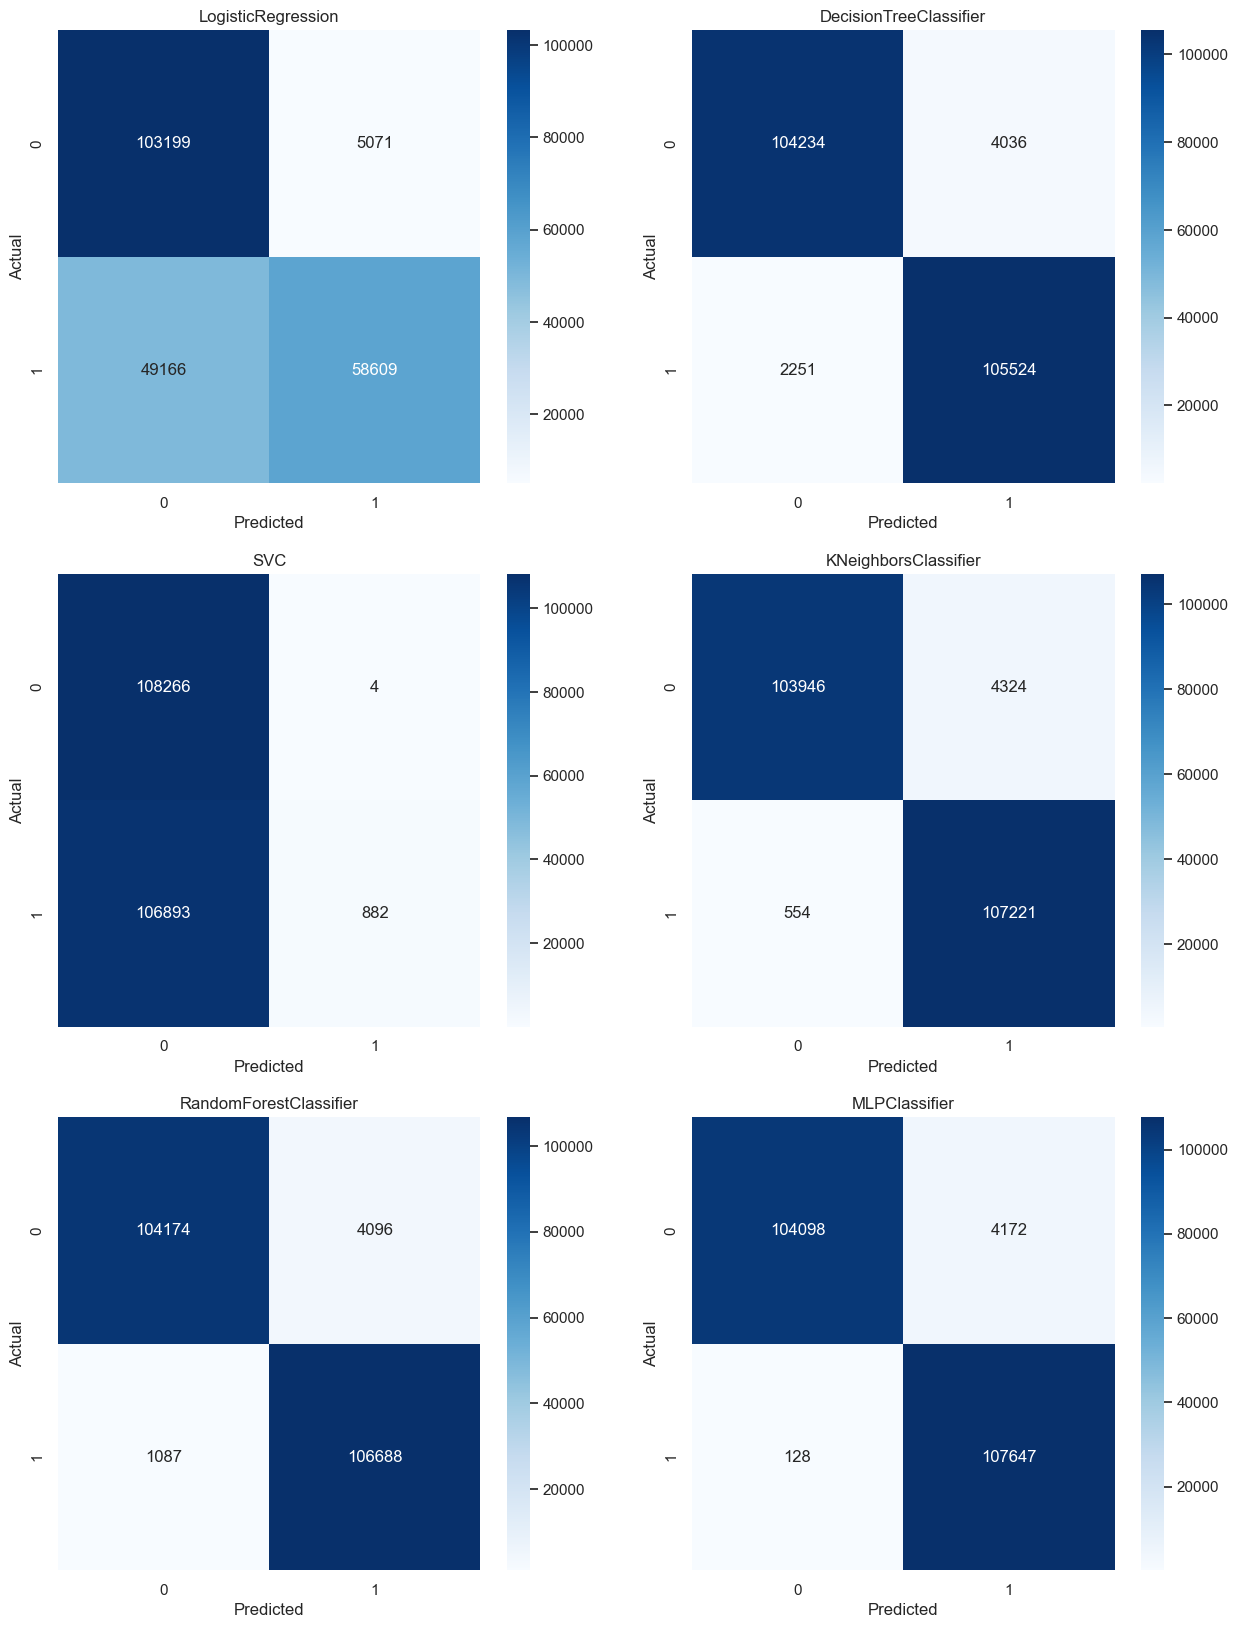

In [119]:
plt.figure(figsize=(15,20))
sns.set(font_scale=1)
for i in range(len(classifiers)):
    plt.subplot(3,2,i+1)
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])
plt.show()

In [128]:
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" );
    print (clr[i]);

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.95      0.79    108270
           1       0.92      0.54      0.68    107775

    accuracy                           0.75    216045
   macro avg       0.80      0.75      0.74    216045
weighted avg       0.80      0.75      0.74    216045

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97    108270
           1       0.96      0.98      0.97    107775

    accuracy                           0.97    216045
   macro avg       0.97      0.97      0.97    216045
weighted avg       0.97      0.97      0.97    216045

SVC Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67    108270
           1       1.00      0.01      0.02    107775

    accuracy                           0.51    216045
   macro avg 

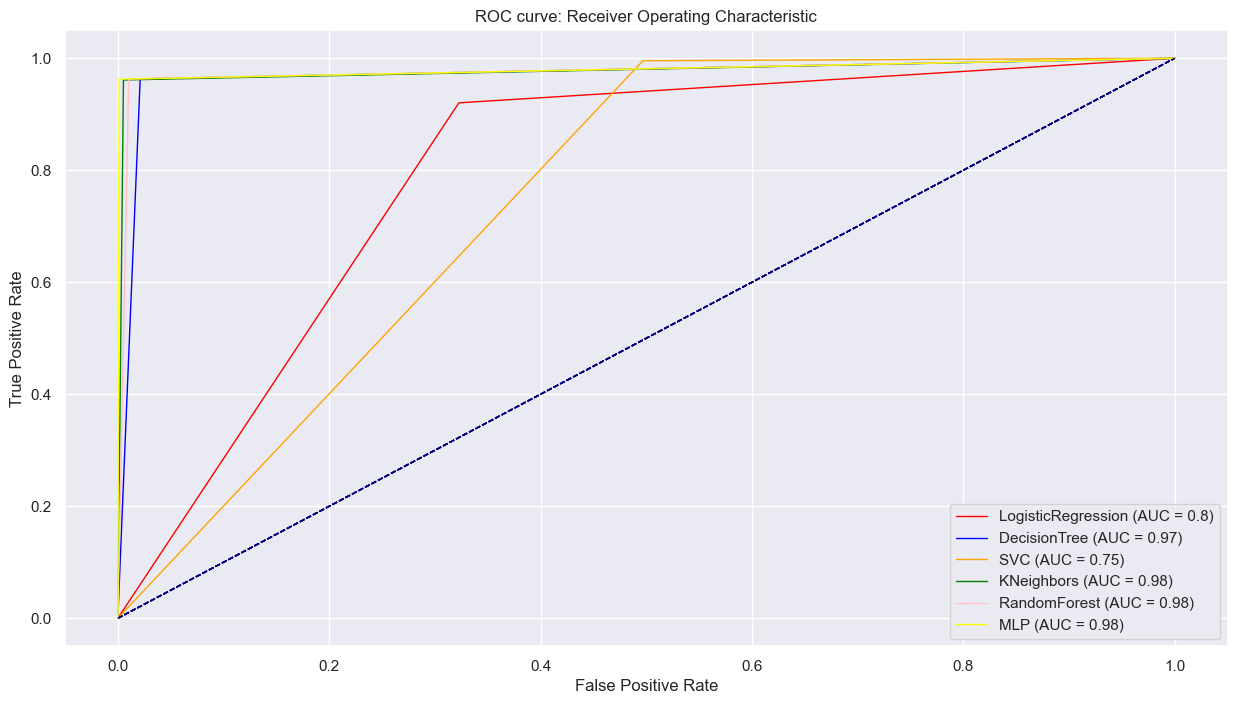

In [121]:
plt.figure(figsize=(15,8))
for i in range(len(classifiers)):
    cm = ['red', 'blue', 'orange', 'green', 'pink', 'yellow', 'lightgreen', 'black', 'purple', 'lightblue']
    plt.plot(roc_fpr[i], roc_tpr[i], c=cm[i], lw=1, label=clf_name[i].replace("Classifier", "") + " (AUC = " + str(round(roc_auc[i],2)) + ")")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Receiver Operating Characteristic')
    plt.legend(loc="lower right")
plt.show()

Classificazione ternaria

In [13]:
label_t = pd.get_dummies(balanced_t["Rating"], prefix = "rating") 
features_t = balanced_t.drop("Rating", axis=1)
rs = 1
train_features_t, test_features_t, train_labels_t, test_labels_t = train_test_split(features_t, label_t, test_size=0.1)

In [14]:
mlp_t = MLPClassifier(hidden_layer_sizes=(10, 20, 40, 6), max_iter=20,
validation_fraction=0.1, early_stopping=True, verbose=True, n_iter_no_change=10,
activation='relu', solver='adam', batch_size=32, momentum=0.9,
learning_rate='adaptive', random_state=rs)

mlp_t.fit(train_features_t, train_labels_t)

Iteration 1, loss = 1.70379931
Validation score: 0.431605
Iteration 2, loss = 1.21266704
Validation score: 0.560420
Iteration 3, loss = 1.11824480
Validation score: 0.586483
Iteration 4, loss = 1.09710350
Validation score: 0.618962
Iteration 5, loss = 1.08737632
Validation score: 0.640869
Iteration 6, loss = 1.07742533
Validation score: 0.629747
Iteration 7, loss = 1.06855214
Validation score: 0.618992
Iteration 8, loss = 1.06507814
Validation score: 0.461181
Iteration 9, loss = 1.06055600
Validation score: 0.640747
Iteration 10, loss = 1.06592103
Validation score: 0.642886
Iteration 11, loss = 1.06269911
Validation score: 0.642244
Iteration 12, loss = 1.05974837
Validation score: 0.627150
Iteration 13, loss = 1.05546204
Validation score: 0.609185
Iteration 14, loss = 1.06035159
Validation score: 0.610071
Iteration 15, loss = 1.07175701
Validation score: 0.647316
Iteration 16, loss = 1.05500051
Validation score: 0.599316
Iteration 17, loss = 1.05345912
Validation score: 0.647988
Iterat

MLPClassifier(batch_size=32, early_stopping=True,
              hidden_layer_sizes=(10, 20, 40, 6), learning_rate='adaptive',
              max_iter=20, random_state=1, verbose=True)

In [16]:
acc_during_train_t = mlp_t.score(train_features_t, train_labels_t)
print('Accuratezza durante il training :', acc_during_train_t)
accuracy_t = mlp_t.score(test_features_t, test_labels_t)
print(f'Accuratezza : {round(accuracy_t, 2)}   ---> {mlp_t.__class__.__name__}')

Accuratezza durante il training : 0.6523183158409337
Accuratezza : 0.65   ---> MLPClassifier


In [17]:
pred_t = mlp_t.predict(test_features_t)

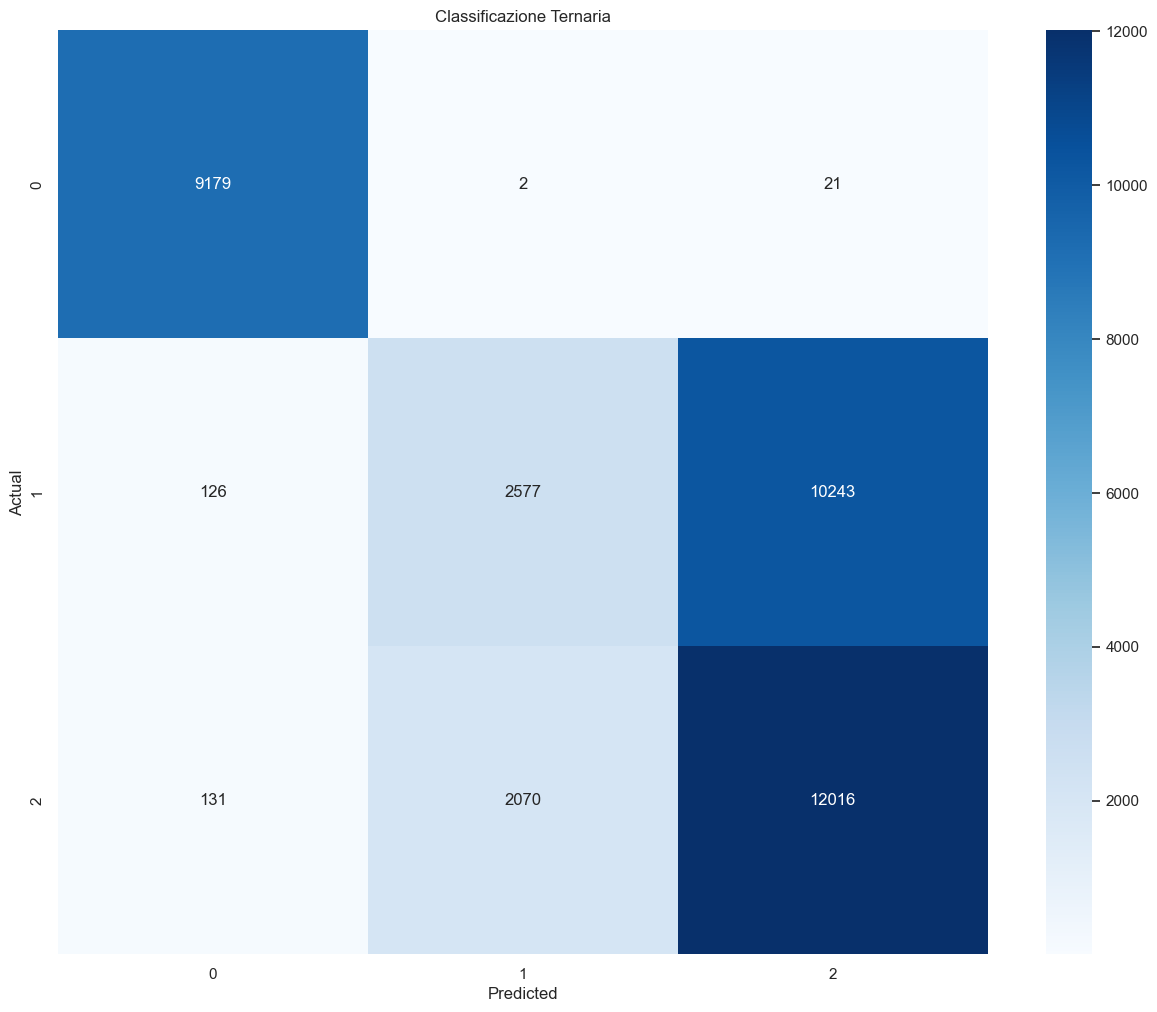

In [20]:
plt.figure(figsize=(15,12))
sns.set(font_scale=1)
c_matrix = confusion_matrix(test_labels_t.values.argmax(axis=1), pred_t.argmax(axis=1))
sns.heatmap(c_matrix, annot=True, fmt="d",cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Classificazione Ternaria')
plt.show()

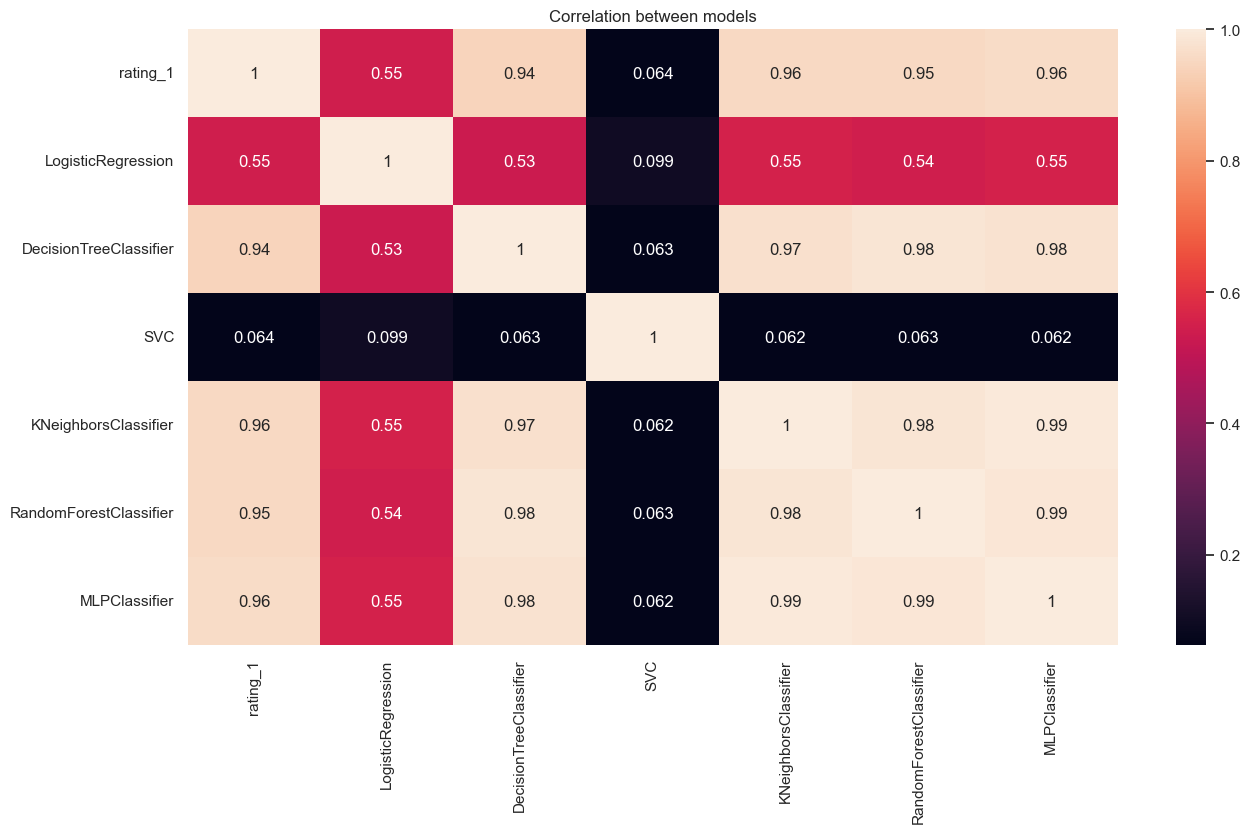

In [131]:
plt.figure(figsize=(15,8))
sns.heatmap(model_results.drop('rating_0', axis=1).corr(),annot=True)
plt.title('Correlation between models')
plt.show()

Testare il modello

In [133]:
best_model = mlp #VotingClassifier(estimators=[('dt', gs_model[0]), ('rf', gs_model[1])], voting='soft', n_jobs=4)
best_model.fit(train_features,train_labels.rating_1)
print(accuracy_score(test_labels.rating_1,best_model.predict(test_features)))

Iteration 1, loss = 0.18043690
Validation score: 0.974861
Iteration 2, loss = 0.10010427
Validation score: 0.978976
Iteration 3, loss = 0.09685550
Validation score: 0.979814
Iteration 4, loss = 0.09399207
Validation score: 0.979634
Iteration 5, loss = 0.09202924
Validation score: 0.979557
Iteration 6, loss = 0.09278976
Validation score: 0.979896
Iteration 7, loss = 0.09207105
Validation score: 0.979613
Iteration 8, loss = 0.09123847
Validation score: 0.979855
Iteration 9, loss = 0.09179292
Validation score: 0.979408
Iteration 10, loss = 0.09168891
Validation score: 0.978718
Iteration 11, loss = 0.09032080
Validation score: 0.979629
Iteration 12, loss = 0.08971218
Validation score: 0.978888
Iteration 13, loss = 0.08982609
Validation score: 0.961988
Iteration 14, loss = 0.08867826
Validation score: 0.979948
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
0.980096739105279


In [137]:
rating = pd.Series(best_model.predict(g_junk.drop(['App Name', 'Rating', 'Installs', 'Appreciation Index', 'Released'], axis=1)), name='Rating')

In [138]:
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve

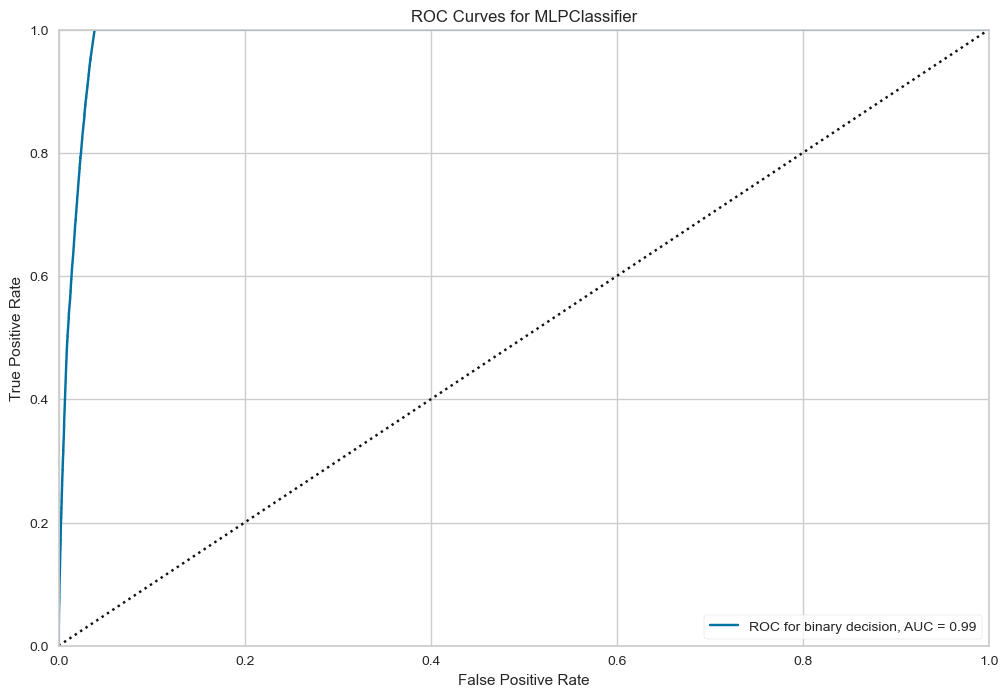

<AxesSubplot:title={'center':'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [143]:
plt.figure(figsize=(12,8))
visualizer = ROCAUC(best_model, classes=['low rated', 'high rated'], micro=False, macro=False, binary=True)
visualizer.fit(train_features, train_labels.rating_1)        
visualizer.score(test_features, test_labels.rating_1)        
visualizer.show()                       

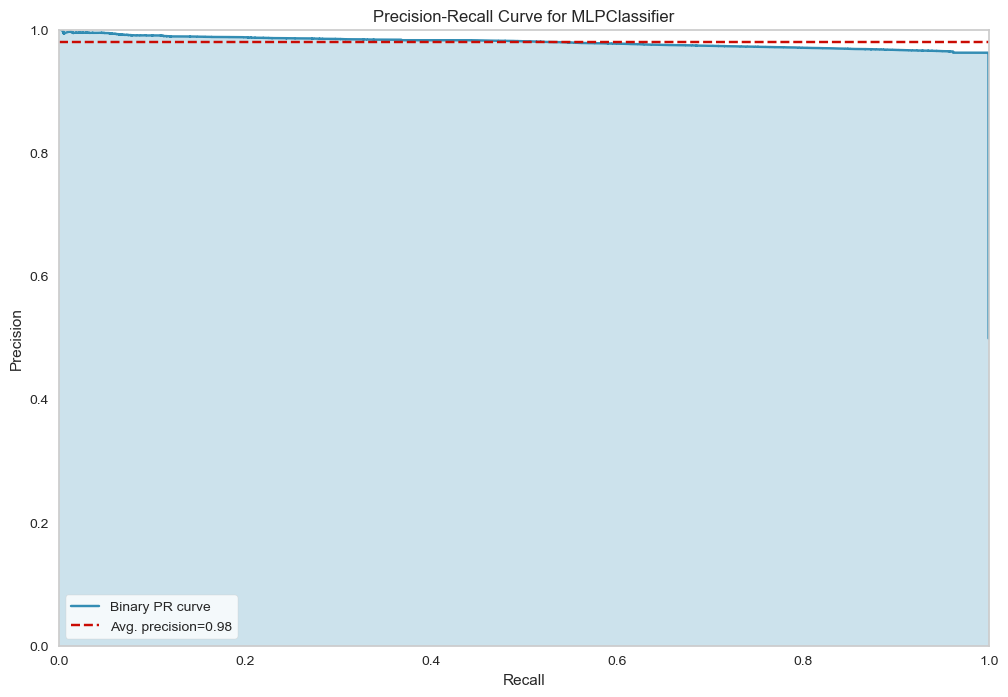

<AxesSubplot:title={'center':'Precision-Recall Curve for MLPClassifier'}, xlabel='Recall', ylabel='Precision'>

In [142]:
plt.figure(figsize=(12,8))
viz = PrecisionRecallCurve(best_model)
viz.fit(train_features, train_labels.rating_1)
viz.score(test_features, test_labels.rating_1)
viz.show()

In [ ]:
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

plt.figure(figsize=(12,8))
visualizer = LearningCurve(
    best_model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(train_features,train_labels.rating_1)
visualizer.show()